In [1]:
import numpy as np
import pandas as pd
import sys
import functools
import matplotlib.pyplot as plt
import ftfy
from time import time
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim.corpora import Dictionary
import gensim.downloader as api

def get_summary(pipeline_func):
    @functools.wraps(pipeline_func)
    def wrapper(*args, **kwargs):
        assert isinstance(args[0], pd.core.frame.DataFrame)
        result_df = pipeline_func(*args, **kwargs)
        assert isinstance(result_df, pd.core.frame.DataFrame)
        print(result_df.shape)

        return result_df

    return wrapper

def get_data(filepath):
    print(f"reading from {filepath}")
    try:
        df = pd.read_csv(filepath)
        return df
    except:
        print("couldn't read data")
        return pd.DataFrame()

def pipeline(df, fns, name):
    intermediate = df
    assert isinstance(intermediate, pd.core.frame.DataFrame)
    print(f"RUNNING {name}")
    for i, fn in enumerate(fns):
        print(f"STEP {i+1}: {str(fn)}")
        intermediate = fn(intermediate)
        assert isinstance(intermediate, pd.core.frame.DataFrame)
        intermediate.reset_index(drop=True, inplace=True)
    print("[DONE] ------------\n")
    return intermediate

@get_summary
def initial(df):
    print(df.keys())
    return df

@get_summary
def top2k(df):
    return df[:2000]

@get_summary
def drop_columns(df):
    result = df[["category", "job_description", "is_fulltime"]]
    return result

@get_summary
def create_binary_job(df):
    df.loc[:, "is_fulltime"] = df.job_type == 'Full Time'
    return df

@get_summary
def task1_fields(df):
    return df[["job_description", "is_fulltime", "tfidf10"]]

def get_category_proportions(df):
    print(df.category.value_counts() / sum(df.category.value_counts()))
    return df

@get_summary
def stratified_undersample_fulltime(df):
    other_count = len(df) - sum(df.is_fulltime)
    assert other_count == sum(~df.is_fulltime)
    
    all_indices = np.arange(len(df))
    fulltime_indices = all_indices[df.is_fulltime]
    other_indices = all_indices[~df.is_fulltime]
    
    # we need to select other_count indices out of the fulltime_indices list without replacement
    
    category_counts = other_count * (df.category.value_counts() / sum(df.category.value_counts()))
    category_counts = category_counts.astype(int)
    resulting_indices = []
    for category in df.category.unique():
        in_category_and_fulltime = all_indices[(df.is_fulltime) & (df.category == category)]
        choices = np.random.choice(in_category_and_fulltime, category_counts[category])
        resulting_indices.extend(choices)
        
    new_df = df.loc[[*resulting_indices, *other_indices]]
    return new_df
    
def display_category_count_stats(df):
    print(f"Category counts: {round(df.category.value_counts().mean(), 2)} ± {round(df.category.value_counts().std(), 2)}")
    return df
    
@get_summary
def delete_dupes(df):
    # Considers duplicate if job description is identical
    df = df.drop_duplicates(subset=["job_description"], keep='first')
    return df

def replace_empty_with_nan(df):
    df['job_description'].replace('', np.nan, inplace=True)
    return df

def which_na(df):
    print(df[df.job_description.isna()].category.value_counts())
    print(df[df.job_description.isna()].company_name.value_counts())
    return df
    
@get_summary
def delete_na(df):
    df.dropna(subset=['job_description'], inplace=True)
    return df
    
@get_summary
def random_undersample_categories(df):
    MAXIMUM_CLASS_COUNT = 1289
    
    undersampled_frame = pd.DataFrame()
    
    for class_name in df.category.unique():
        class_count = sum(df.category == class_name)
        if class_count > MAXIMUM_CLASS_COUNT:
            # Need to undersample this class
            undersampled = df[df.category == class_name].sample(MAXIMUM_CLASS_COUNT)
            undersampled_frame = pd.concat([undersampled_frame, undersampled])
        else:
            undersampled_frame = pd.concat([undersampled_frame, df[df.category == class_name]])
    
    return undersampled_frame

@get_summary
def random_oversample_categories(df):
    MINIMUM_CLASS_COUNT = 502
    
    oversampled_frame = pd.DataFrame()
    
    for class_name in df.category.unique():
        class_count = sum(df.category == class_name)
        if class_count < MINIMUM_CLASS_COUNT:
            # Need to oversample this class
            required_to_add = MINIMUM_CLASS_COUNT - class_count
            additional = df[df.category == class_name].sample(required_to_add, replace=True)
            oversampled_frame = pd.concat([oversampled_frame, additional])
        oversampled_frame = pd.concat([oversampled_frame, df[df.category == class_name]])
            
    return oversampled_frame
    
@get_summary
def naive_undersample_fulltime(df):
    other_count = len(df) - sum(df.is_fulltime)
    all_indices = np.arange(len(df))
    fulltime_indices = all_indices[df.is_fulltime]
    other_indices = all_indices[~df.is_fulltime]
    new_df = df.loc[[*np.random.choice(fulltime_indices, other_count), *other_indices]] 
    
    return new_df
    
def tokenise(df):
    df['job_description'] = df.job_description.apply(lambda entry: gensim.utils.simple_preprocess(str(entry), deacc=True)) 
    return df
    
@get_summary
def task2_fields(df):
    return df[["job_description", "category", "tfidf10"]]

def display_balance(df):
    fulltime_prop = sum(df.is_fulltime) / len(df)
    print(f"FULL TIME %: {round(fulltime_prop * 100, 2)}%")
    print(f"OTHER %: {round((1 - fulltime_prop) * 100, 2)}%")
    return df

def fix_encoding(df):
    df.loc[:, 'job_description'] = [ftfy.fix_text(jd) for jd in df.job_description]
    return df
    
def add_tfidf_top10(df):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform([' '.join(jd) for jd in df.job_description])

    names = tfidf_vectorizer.get_feature_names_out()
    top10s = []
    for i in range(tfidf_vectorizer_vectors.shape[0]):
        if i % 10000 == 0:
            print(f"{i} records done")
        vector = tfidf_vectorizer_vectors[i].toarray()[0]
        top10 = np.argpartition(vector, -10)[-10:]
        top10s.append(names[top10])
    
    df['tfidf10'] = pd.Series(top10s)
    
    return df

def train_val_test(data, train, val, test):
    assert train + val + test == 1
    training, other = train_test_split(data, train_size=train, shuffle=True)
    validate, testing = train_test_split(data, train_size=val, test_size=test, shuffle=True)
    
    return training, validate, testing

# Preprocessing Pipeline

In [2]:
origin_df = get_data('../data/seek_australia.csv')
result = pipeline(origin_df, [initial, create_binary_job, replace_empty_with_nan, which_na, delete_na, fix_encoding, delete_dupes, drop_columns, tokenise, add_tfidf_top10], "Initial pipeline")
task1_result = pipeline(result, [display_balance, stratified_undersample_fulltime, display_balance, task1_fields], "Task 1 pipeline")
task2_result = pipeline(result, [task2_fields, display_category_count_stats, random_undersample_categories, random_oversample_categories], "Task 2 pipeline")

reading from ../data/seek_australia.csv
RUNNING Initial pipeline
STEP 1: <function initial at 0x7f3415eaea60>
Index(['category', 'city', 'company_name', 'geo', 'job_board',
       'job_description', 'job_title', 'job_type', 'post_date',
       'salary_offered', 'state', 'url'],
      dtype='object')
(30000, 12)
STEP 2: <function create_binary_job at 0x7f3415eaedc0>
(30000, 13)
STEP 3: <function replace_empty_with_nan at 0x7f3415eb4310>
STEP 4: <function which_na at 0x7f3415eb43a0>
Information & Communication Technology    38
Manufacturing, Transport & Logistics      36
Trades & Services                         35
Legal                                     25
Healthcare & Medical                      25
Administration & Office Support           25
Marketing & Communications                21
Sales                                     20
Education & Training                      14
Hospitality & Tourism                     14
Government & Defence                      14
Construction       

In [3]:
def save_split(train, val, test, name):
    train.to_csv(f'../data/{name}-train.csv')
    test.to_csv(f'../data/{name}-test.csv')
    val.to_csv(f'../data/{name}-val.csv')
    
    
def save_results(results):
    for name,result in results.items():
        result.to_csv(f'../data/{name}.csv')
        train, val, test = train_val_test(result, 0.7, 0.1, 0.2)
        save_split(train, val, test, name)

# t1_train, t1_val, t1_test = train_val_test(task1_result, 0.7, 0.1, 0.2)
# t2_train, t2_val, t2_test = train_val_test(task2_result, 0.7, 0.1, 0.2)

# save_split(t1_train, t1_val, t1_test, "task_1")
# save_split(t2_train, t2_val, t2_test, "task_2")

In [4]:
save_results(
    {
        "task1": task1_result,
        "task2": task2_result
    }
)

In [5]:
task2_result

,job_description,category,tfidf10
0,"[have, you, had, years, experience, in, fresh,...",Retail & Consumer Products,"[the, sebastian, produce, and, for, store, wad..."
1,"[about, us, retail, safari, as, part, of, cpm,...",Retail & Consumer Products,"[safari, cpm, conversational, engaging, person..."
2,"[work, with, brand, you, love, wear, generous,...",Retail & Consumer Products,"[know, and, store, wear, sneakers, you, star, ..."
3,"[about, the, company, forever, new, is, one, o...",Retail & Consumer Products,"[late, new, to, beauty, her, forever, the, cel..."
4,"[sunglass, hut, is, global, retailer, with, st...",Retail & Consumer Products,"[chanel, ban, dolce, prada, oakley, gabbana, s..."
...,...,...,...
24708,"[job, no, queensland, brain, institute, the, q...",Science & Technology,"[zhaoyu, qbi, and, cell, research, neuroscienc..."
24709,"[to, support, company, growth, my, client, are...",Science & Technology,"[pic, gmp, ensure, manage, qa, approval, valid..."
24710,"[school, of, biomedical, sciences, the, univer...",Science & Technology,"[therapeutics, nanotechnology, school, biomedi..."
24711,"[job, no, location, clayton, campus, employmen...",Science & Technology,"[to, feeling, science, dean, of, monash, and, ..."


# Job description-less jobs:

There are a few companies (170 unique companies) which have made job listings with no job description. Unfortunately, these listings will be removed from the dataset.

Here's a small subsection of the companies and how many empty job listings they've made so that we're aware of the bias we're introducing:
```
Kaleidoscope Legal Recruitment          23
Excel Recruitment                       16
Private Advertiser                      11
Department of Education and Training    10
Melbourne Water                          7
...
Genea                                    1
Platinum People Solutions                1
Camnet                                   1
Blue Line Cruises                        1
Metro Ice Cream Distribution Pty Ltd     1
```

# Dealing with Data Imbalance

## Task 1

### Undersampling
In our case, some classes appear more frequently than others. (e.g. there are more full time jobs than any other kind). We want to try to ensure an equal balance between our classes. Since our dataset is relatively large, we can afford to undersample, this is the process where we intentionally remove samples from our larger class, reducing the overall size of our dataset.
Naively undersampling the `is_fulltime` field will result in a biased dataset. This is because we are ignoring our knowledge of the various job categories. By naively undersampling we are probably going to change the proportion of the different job categories, e.g. we just happen to (by bad luck) disproporitonately remove a bunch of law firm jobs. This will hence skew the `job_description` data. In an attempt to mitigate this issue, we will attempt to keep the category proporitions the same when we undersample from the `is_fulltime` column. Hence we will perform a **stratified** sample of the data where the strata are the various categories.

## Task 2

### Undersampling & Oversampling
Will perform over and undersampling to try and improve class balance. The mean number of data points per class is calculated above (895.03) and the standard deviation is too (787.01). Based purely on intuition, I will resample so that the maximum number of data points per class is is  
`895 + 0.5 * 787 = 1289` and the minimum number is `895 - 0.5 * 787 = 502`. So in total, our range of data point counts per class will span from 36 to 98 (still unideal, but better than initially). 895.03 ± 787.01

# What the datasets look like now:

In [6]:
task1_result

,job_description,is_fulltime,tfidf10
0,"[about, us, world, renowned, in, jewellery, an...",True,"[objection, maison, and, service, legends, cre..."
1,"[multi, site, customer, service, officer, bond...",True,"[and, the, stores, customers, to, touch, heari..."
2,"[higher, solution, specialists, is, privately,...",True,"[hss, and, ensuring, sales, jewellery, luxury,..."
3,"[about, the, company, thorn, is, one, of, aust...",True,"[pool, sales, store, driven, radio, and, thorn..."
4,"[retail, management, roles, up, for, grabs, op...",True,"[sassine, bonuses, street, manaer, wetherill, ..."
...,...,...,...
17726,"[about, us, kaplan, australia, is, one, of, th...",False,"[education, campus, to, of, the, student, and,..."
17727,"[full, time, maximum, term, position, months, ...",False,"[of, implementation, review, business, system,..."
17728,"[mondelez, international, is, currently, seeki...",False,"[the, international, merchandiser, outlet, to,..."
17729,"[long, term, contract, for, months, with, poss...",False,"[department, managers, agencies, and, grant, g..."


In [7]:
task2_result

,job_description,category,tfidf10
0,"[have, you, had, years, experience, in, fresh,...",Retail & Consumer Products,"[the, sebastian, produce, and, for, store, wad..."
1,"[about, us, retail, safari, as, part, of, cpm,...",Retail & Consumer Products,"[safari, cpm, conversational, engaging, person..."
2,"[work, with, brand, you, love, wear, generous,...",Retail & Consumer Products,"[know, and, store, wear, sneakers, you, star, ..."
3,"[about, the, company, forever, new, is, one, o...",Retail & Consumer Products,"[late, new, to, beauty, her, forever, the, cel..."
4,"[sunglass, hut, is, global, retailer, with, st...",Retail & Consumer Products,"[chanel, ban, dolce, prada, oakley, gabbana, s..."
...,...,...,...
24708,"[job, no, queensland, brain, institute, the, q...",Science & Technology,"[zhaoyu, qbi, and, cell, research, neuroscienc..."
24709,"[to, support, company, growth, my, client, are...",Science & Technology,"[pic, gmp, ensure, manage, qa, approval, valid..."
24710,"[school, of, biomedical, sciences, the, univer...",Science & Technology,"[therapeutics, nanotechnology, school, biomedi..."
24711,"[job, no, location, clayton, campus, employmen...",Science & Technology,"[to, feeling, science, dean, of, monash, and, ..."


Text(0.5, 0, 'Class')

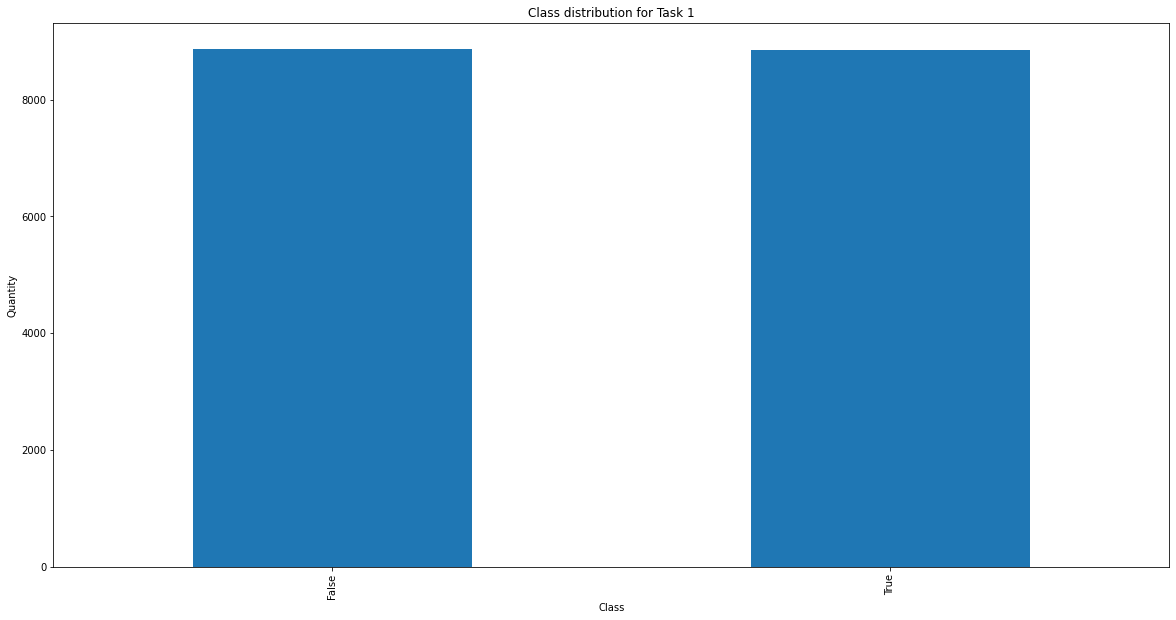

In [8]:
task1_result.is_fulltime.value_counts().plot.bar()
plt.title("Class distribution for Task 1")
plt.ylabel("Quantity")
plt.xlabel("Class")

<AxesSubplot:>

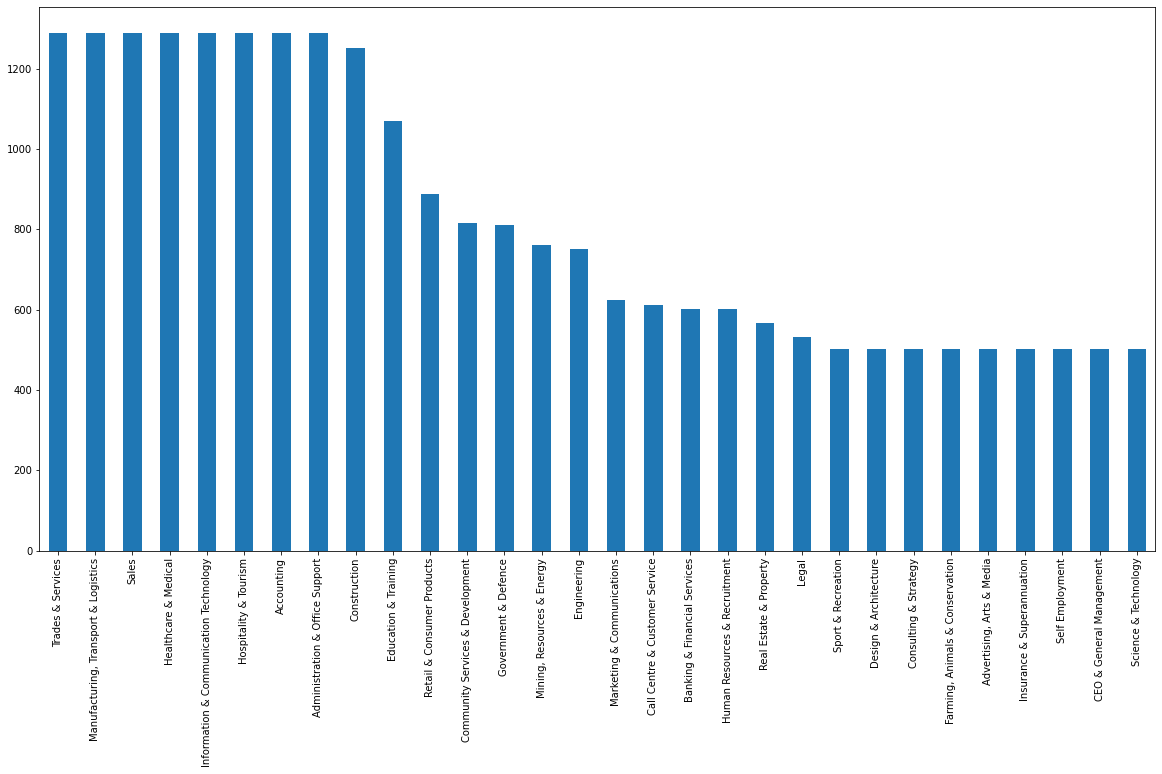

In [9]:
task2_result.category.value_counts().plot.bar()

In [10]:
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet
import pandas as pd

In [11]:
def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # Define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

def model_base():
    cores = 4
    model = Word2Vec(min_count=1,
                     window=2,
                     vector_size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
    return model

def build_vocab(model, job_descriptions):
    t = time()
    model.build_vocab(job_descriptions, progress_per=10)
    print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

def train_model(model, job_descriptions):
    t = time()
    model.train(job_descriptions, total_examples=model.corpus_count, epochs=50, report_delay=1)
    print('Time to train : {} mins'.format(round((time() - t) / 60, 2)))
    
def create_model(load_path=None):
    if not load_path:
        model = model_base()
        build_vocab(model, result.job_description)
        train_model(model, result.job_description)
    else:
        model = gensim.models.KeyedVectors.load(load_path)

    return model

def convert(tup, dicti):
    for a, b in tup:
        dicti[a] = b
    return dicti
    
def visualise_document(document, model):
    print('starting')
    dictionary = Dictionary()
    BoW_corpus = dictionary.doc2bow(document, allow_update=True)
    BoW_corpus = [(dictionary[id], freq) for id, freq in BoW_corpus]
    BoW_corpus_dict = dict()
    convert(BoW_corpus, BoW_corpus_dict)
    print('bow created')
    vocab_sorted = dict(sorted(BoW_corpus_dict.items(), key=lambda item: item[1], reverse=True))
    sw = stopwords.words('english')
    print('sorted vocab')
    input_vocab =  [word for word in vocab_sorted if word in model.wv.key_to_index.keys() and word not in sw]
    points = len(input_vocab)
    print('starting tsne')
    tsne = TSNE(n_components=2, random_state=0)
    X = model.wv[input_vocab]
    X_tsne = tsne.fit_transform(X[:points])
    print('tsne done')
    interactive_tsne(list(input_vocab)[:points], X_tsne)
    

In [ ]:
corpus = [item for sublist in result.job_description[:50] for item in sublist]
# model = create_model('./my_model.xyz')
model = create_model()
visualise_document(corpus, model)

Time to build vocab: 0.03 mins


# Create 3 different model types:
## Domain specific
Already written above

## Pretrained

In [ ]:
import gensim.downloader as api

def create_pretrained(load_path=None):
    if not load_path:
        pretrained_w2v = api.load('word2vec-google-news-300')
        return pretrained_w2v
    else:
        return gensim.models.KeyedVectors.load(load_path)

In [ ]:
# pretrained_w2v = create_pretrained('./pretrained_w2v.xyz')
pretrained_w2v = create_pretrained()

## One-Hot vectoriser

In [40]:
def get_one_hot_vectoriser(corpus):
    dictionary = Dictionary(corpus)
    
    def one_hot_vectoriser(word):
        indx = dictionary.token2id[word]
        # could throw an exception here I guess
        vec = np.zeros(2928)
        vec[indx] = 1
        return vec
    
    return one_hot_vectoriser

In [41]:
one_hot = get_one_hot_vectoriser([corpus])

In [42]:
origin_df.job_description[3]

"About the role: We are seeking an Automotive Workshop Technician to join our busy Springvale workshop. In this role you will be responsible for Pre-Delivery inspections, troubleshooting, scheduled maintenance as well as more involved technical repairs of forklifts. \xa0 What's on offer? We offer above award wages in line with experience and our team members receive ongoing technical training, access to paid forklift training and certification plus onsite parking. We have a proven track record of promoting our team members so career development is a genuine reality if you're serious about establishing your career within Material Handling. About you: You will have a Mechanical Trade Certificate and mechanical experience including servicing and diagnostics gained in any mechanical industry. We're looking for people with a strong commitment to safe work practices and good communication skills. You will be no stranger to working in a fast paced environment to meet changing deadlines and en